 # Tutorial 08 - Machine Learning
 
 ## Dr. David C. Schedl

 Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Digital Imaging / Computer Vision** techniques.



## Setup
As first step, we need to import the necessary libraries. 

In [1]:
# Setup and import of libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs, make_circles


# Let's set the random seed to make this reproducible (the same for everybody).
np.random.seed(1337)
random.seed(1337)

# Computing Gradients
Let's start simple with the quadratic function $f(x) = 3x^2 - 4x + 5$.

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

Let's plot it in the range $[-5, 5]$.

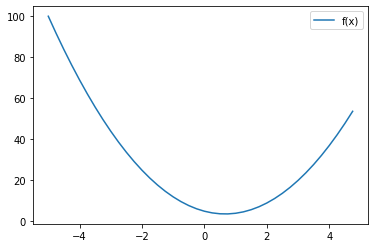

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, label="f(x)")
plt.legend()
plt.show()

The derivative of this function is $\frac{df(x)}{dx} = 6x - 4$.

The minimum ($0 = \frac{df(x)}{dx}$) is at $x = \frac{4}{6} = \frac{2}{3}$.

Let's numerically derive the function and let's look at some values. 

In [4]:
h = 0.000001
x = -4  # test with -4, 0, 2/3 and 4
(f(x + h) - f(x)) / h

-27.999997001870724

## Simple Gradient Descent

With the gradient we can now implement a simple gradient descent algorithm, which iteratively updates the value of $x$ in the direction of the negative gradient.
The parameters are the learning rate (often denoted as $\alpha$) and the number of iterations $N$.

🤔 What happens if you change the learning rate or the number of iterations?

x' reached: 0.535 after 10 iterations and should be 0.667!


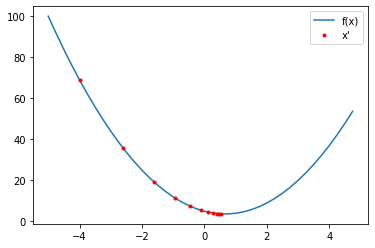

In [5]:
# simple gradient descent

x = -4
_xs = [x]
learning_rate = 0.05
N = 10  # number of iterations
for i in range(N):
    df = (f(x + h) - f(x)) / h
    x = x - learning_rate * df
    _xs.append(x)

print(f"x' reached: {x:.3f} after {N} iterations and should be {2/3:.3f}!")
plt.plot(xs, ys, label="f(x)")  # plot the function
plt.plot(
    _xs, f(np.array(_xs)), "r.", label="x'"
)  # plot the path our gradient descent took
plt.legend()
plt.show()

## The same with PyTorch

Let's reuse the quadratic function $f(x) = 3x^2 - 4x + 5$.

PyTorch implements backpropagation. 
After calling `backward` every tensor involved in the computation has a gradient (`.grad`).

In [6]:
import torch

# test with -4, 0, 2/3 and 4
x = torch.Tensor([-4]).double()
x.requires_grad = True

# the quadratic function
f = 3 * x**2 - 4 * x + 5

print("f =", f.data.item())

f.backward()  # with backward we compute the gradients

print("---")
print("gradient x =", x.grad.item())

f = 69.0
---
gradient x = -28.0


In [7]:
x = torch.Tensor([-4]).double()
x.requires_grad = True


# Let's use an optimizer
optimizer = torch.optim.SGD(
    [x],
    lr=learning_rate,  # learning rate
)

N = 10  # number of iterations

# optimization
for k in range(N):

    # sets all gradients to zero (this is important)
    optimizer.zero_grad()

    # compute the quadratic function
    f = 3 * x**2 - 4 * x + 5

    f.backward()

    # update x (sgd)
    optimizer.step()
    # the same as
    # x -= learning_rate * x.grad.item() # NOTE: does not run!

    print(f"step {k}, gradient x = {x.grad.item()}")

print(f"---")
print(f"x' reached: {x.data.item():.3f} after {N} iterations and should be {2/3:.3f}!")

step 0, gradient x = -28.0
step 1, gradient x = -19.599999999999998
step 2, gradient x = -13.719999999999999
step 3, gradient x = -9.604
step 4, gradient x = -6.7227999999999986
step 5, gradient x = -4.705959999999999
step 6, gradient x = -3.2941719999999988
step 7, gradient x = -2.3059203999999993
step 8, gradient x = -1.6141442799999997
step 9, gradient x = -1.129900996
---
x' reached: 0.535 after 10 iterations and should be 0.667!


# Recap: Naive Line Fitting (from Tutorial 07)

Let's look at a simple example of line fitting, where we try to fit a line with a simple line equation: $y = mx + b$.
We use the `scipy.optimize` package to fit the line to the data. <br>
Note that this will only work for a single line and breaks if there are multiple lines or noise in the data.

1.0 -7.000000000000001


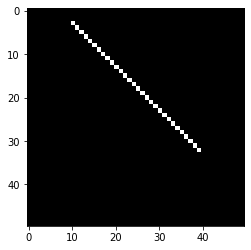

In [8]:
from scipy.optimize import curve_fit

image = np.zeros((50, 50), dtype=np.uint8)
image[3:33, 10:40] = np.eye(30) * 255
# let's add random noise (off if N=0)
N = 0
image[np.random.randint(0, 50, N), np.random.randint(0, 50, N)] = 255


# get all the non-zero points
points = np.argwhere(image)
ys, xs = points[:, 0], points[:, 1]

# a simple line equation y = mx + b (m is the slope, which you might also know as k)
def line_eq(x, m, b):
    return m * x + b


# find m and b
(m, b), _ = curve_fit(line_eq, xs, ys)
print(m, b)


# yshat = line_eq(xs, m, b)

# show
plt.imshow(image, cmap="gray")
# plt.plot(xs, line_eq(xs, m, b))
plt.show()

## Let's solve it with PyTorch

The initial model parameters are: m=0.100, b=0.000
The initial loss is: 8615.550
step 0, loss = 8615.550
step 100, loss = 121.234
step 200, loss = 50.133
step 300, loss = 15.461
step 400, loss = 3.649
step 500, loss = 0.665
step 600, loss = 0.094
step 700, loss = 0.010
step 800, loss = 0.001
step 900, loss = 0.000


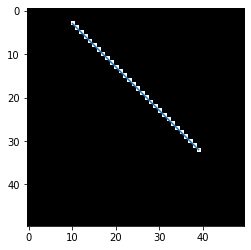

The final model parameters are: m=1.000, b=-6.999
The final loss is: 0.000


In [22]:
import torch
import torch.nn as nn

# Convert numpy array to torch tensors
_xs = torch.from_numpy(xs).float()
_ys = torch.from_numpy(ys).float()

# define the model parameters (m and b)
_m = torch.Tensor([.1]).float()
_m.requires_grad = True
_b = torch.Tensor([0]).float()
_b.requires_grad = True


# Define loss function and optimizer
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam([_m, _b], lr=1e-1)

print(f"The initial model parameters are: m={_m.item():.3f}, b={_b.item():.3f}")
yhat = line_eq(_xs, _m, _b)
loss = criterion(yhat, _ys)
print(f"The initial loss is: {loss.item():.3f}")

# Train the model
for epoch in range(1000):
    optimizer.zero_grad()
    yhat = line_eq(_xs, _m, _b)
    loss = criterion(yhat, _ys)
    loss.backward() # compute gradients
    optimizer.step() # update parameters (m and b)

    if epoch % 100 == 0:
        print(f"step {epoch}, loss = {loss.item():.3f}")


# Show the image
plt.imshow(image, cmap="gray")
yhat = line_eq(_xs, _m, _b)
plt.plot(xs, yhat.detach().numpy())
plt.show()

print(f"The final model parameters are: m={_m.item():.3f}, b={_b.item():.3f}")
print(f"The final loss is: {loss.item():.3f}")

### Exercise 1 📝: Play with the hyper parameters
 
Change the initial parameters ($m,b$) and the hyperparameters and see how it affects traininig. 
Furthermore, try to change the optimizer (see the [PyTorch docs](https://pytorch.org/docs/stable/optim.html#algorithms)) and see how it affects the training. For example, try to use the `SGD` optimizer.